# HADUK-Grid (CEDA data) 

### Exploring data with iris
#### Overview
* in this notebook ill go through using iris to explore gridded data and meta data 
* iv downloaded 4 cubes from CEDA we will explore here
    * UK 12km rainfall
    * UK 1km rainfall
    
#### Prerequisites
* __Please see 03_aircraft_data.pynb for instructions on ceda certificates. The valid CEDA certificate must be linked to in the specfied environment file below__

To successfully navigate this notebook, you should be accustom with:
* Basics of python programming:
    * loading modules 
    * variable assignment 
    * basic plotting packages (`Matplotlib.pyplot`)
* Basic knowledge of arrays and indexing
* Have a basic understanding of weather and climate, for example:
    * Latitude is North-South
    * Longitude is East-West
    
#### Leaning Outcomes 
After this notebook you should have the basic skills to:
* Explore a Iris cube
    * Access the cubes data 
        * Understand what Lazy data is and why its important 
        * Understand masked data and how its used in Geospatial data
    * Access and understand Meta-data
        * Be able to identify a unknown cube by accessing the Metadata 
        * Be able to modify and adapt Metadata for useful purposes- eg concatenate
* Produce Visualizations to better understand the data
    * Plotting using `iris`
        * Maps using `pcolormesh`
        * Histograms, box plots etc 
        
### Background 
* [Iris](https://scitools-iris.readthedocs.io/en/stable/) is a Python module, produced by the Met Office to allow easy access to Geospatial Data 
* Iris functions well with well known modules like `Matplotlib` and `Numpy`
* Iris stores data in Cubes- representing the dimensions of the earth:
    * Latitude
    * Longitude
    * Time
* These cubes can be analysed in different dimensions to extract relevant information

    
### Contents 

#### Section 0
* Getting the data

#### Section 1 
* Access metadata
* Quickly visualise data 

#### Section 2 
* Collapsing a cube 
* Sub-setting a cube

#### Section  3
* Concatenating cubes
* Lazy data
* masked data 

#### Section 4
* Plots of statistics
    * Box-plots
    * Histograms
    


In [15]:
# Firstly we will load some python packages
import iris
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import requests

In [9]:
# notebook settings
env_file_path = ".env"

HIDE_SECRET_OUTPUT = True

path_to_save_data = './data/HadUK'

For this notebook, a .env file is defined in order to abstract away keys personal to the user. The .env file is kept in the same directory as this notebook. Here is an example of what the .env file looks like:

```
ATMOSPHERIC_CLIENT_ID=xxxxxxxxxxxxxxxxxxxxxx
ATMOSPHERIC_CLIENT_SECRET=xxxxxxxxxxxxxxxxxxxxxx
SOME_OTHER_ENV_VAR=2gt2t1t2t7224pZ/*321
```

As shown, the format for each variable is ENV_VAR_NAME=ENV_SECRET with no spaces between the '=' and the definitions, or at the beginning of a line. A newline is required between each environment variable.
<br>Due to how the file is read without a the common tool `dotenv`, the .env file expects no comments, nor an in-file informational header. The names of each variable should be obvious.
<br>
<br>A __template file for .env__ is given in the repository called `.env_template`. after filling in the template with the users own information, either rename the file itself, or the path to the file in the setting variable above (env_file_path)

In [7]:
# read environment file
env_vars = {}

with open(env_file_path) as f:
    for line in f:
        key, value = line.strip().split("=", 1)
        env_vars[key] = value

print(env_vars)
if HIDE_SECRET_OUTPUT:
    clear_output()

In [8]:
# load environment variables
CERT_SECRET = env_vars["CEDA_CERTIFICATE_DIRECTORY"]

## Section 0

step 0: get the data using a hardcoded link to the file and ceda certification

In [17]:
links_to_data = [
    'https://dap.ceda.ac.uk/badc/ukmo-hadobs/data/insitu/MOHC/HadOBS/HadUK-Grid/v1.0.0.0/1km/tas/ann/v20181126/tas_hadukgrid_uk_1km_ann_188901-188912.nc',
    'https://dap.ceda.ac.uk/badc/ukmo-hadobs/data/insitu/MOHC/HadOBS/HadUK-Grid/v1.0.0.0/12km/rainfall/day/v20181126/rainfall_hadukgrid_uk_12km_day_18910101-18910131.nc',
    'https://dap.ceda.ac.uk/badc/ukmo-hadobs/data/insitu/MOHC/HadOBS/HadUK-Grid/v1.0.0.0/12km/rainfall/day/v20181126/rainfall_hadukgrid_uk_12km_day_18910101-18910131.nc',
    'https://dap.ceda.ac.uk/badc/ukmo-hadobs/data/insitu/MOHC/HadOBS/HadUK-Grid/v1.0.0.0/12km/rainfall/day/v20181126/rainfall_hadukgrid_uk_12km_day_18910201-18910228.nc'
]
paths_to_data = []

for link in links_to_data:
    nc_file_name = link.split("/")[-1]
    file_save_path = path_to_save_data + '/' + nc_file_name
    
    paths_to_data.append(file_save_path)
    if not os.path.exists(
        file_save_path
    ):  # don't download files if already exist on disk
        response = requests.get(link, cert=(CERT_SECRET))
        response_content = response.content
        if response.status_code != 200:
            print(response_content)
            print(
                "\n!!!Exception, likely the certificate is not valid! response above!!!\n"
            )
            raise Exception()
        with open(file_save_path, "wb") as f:
            f.write(response_content)

# print(paths_to_data)

* Next we can load in a cube
* Ill store the directory where my data come from under D_dir, so i can reuse throughout the notebook
* Ill then create the filename by adding my netcdf file
* Finally load a cube list using iris.load()

In [18]:
cubelist = iris.load(paths_to_data[0])

/var/tmp/ipykernel_22849/1587619747.py:1: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  cubelist = iris.load(paths_to_data[0])


Sometimes theres more than one cube in a file, this is particularly true when dealing with pp files from model data.
This is why the cubes are loaded in as a list

## Section 1

In [19]:
print(cubelist)

0: air_temperature / (degC)            (time: 1; projection_y_coordinate: 1450; projection_x_coordinate: 900)


Can see we only have one cube in our list at index 0, by indexing the list we can extract out our air_temperature cube

In [20]:
air_temp = cubelist[0]

###### we can also just load the cube, rather then a list of cubes 
if we want one specific cube from a list of cubes within the files we can constrain our loading based on things
like the title of the cube, its stash code or model levels for more information on constraining cubes, see the [iris docs]( https://scitools-iris.readthedocs.io/en/stable/userguide/loading_iris_cubes.html)

In [23]:
constraint = iris.NameConstraint(standard_name='air_temperature')
air_temp1 = iris.load_cube(paths_to_data[0],constraint)

/var/tmp/ipykernel_22849/1986752391.py:2: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  air_temp1 = iris.load_cube(paths_to_data[0],constraint)


PLease note here since we only have one cube, we don't actually need the constraint. However i included it as an example on how you would constrain for one particular cube in a file if we were dealing with larger files

In [24]:
air_temp1 # gives the same result as indexing the list 

<iris 'Cube' of air_temperature / (degC) (time: 1; projection_y_coordinate: 1450; projection_x_coordinate: 900)>

In [25]:
air_temp

<iris 'Cube' of air_temperature / (degC) (time: 1; projection_y_coordinate: 1450; projection_x_coordinate: 900)>

We can now see a lot more information about the data we have 
The main features are 
* Dimension coordinates
    * we have a time dimension of length 1, making the cube 2D
    * we have projected_y_coordinate, this is North-South
    * we have projected_x_coordinate, this is East_West
* Auxiliary Coordinates
    * latitude and longitude
We will come onto Aux coordinates more later - Since the earth is round, theres many projections we can use to project this sphere onto a 2D square plain
* Cell methods
    * the cell method is describing what kind of data we have, which seems to be mean air temperature over time
* Attributes
    * Attributes tell us more additional information 
    * this data comes from HadUK-Grid v1.0.0.0
    * its describing mean air temperature, over the uk at an annual frequency
    * produced by the met office
    * various names and additional information
    
We haven't done a lot so far, but the cube format has allowed us to learn a lot about the data we are dealing with

NOTE: There are many ways to represent points on the spherical earth in a 2D plane. Some are more intuitive then others and i would'nt worry about it to much in this notebook. projected_y_coordinate and projected_x_coordinate are different ways of representing latitude and longitude respectively. 
    

* The next thing we will do is print some coordinates
* Printing coordinates tells us more about what our data represents

In [26]:
print(air_temp.coords('time'))

[<DimCoord: time / (hours since 1800-01-01 00:00:00)  [1889-07-02 12:00:00]+bounds>]


This tells us lots of information:
* Time units are hours since 1800-01-01 00:00:00 
* Calender is gregorian
* we also have some bounds 

We can also extract times and represent them in different ways, for example:
* using .cell() index's the list of times in the array, so we can only index at 0 in this case
* then .point extracts that time-point, which is a cftime object

In [27]:
time_point = air_temp.coord('time').cell(0).point

In [28]:
print(time_point)
time_point

1889-07-02 12:00:00


cftime.DatetimeGregorian(1889, 7, 2, 12, 0, 0, 0, has_year_zero=False)

Note how printing using print and just the variable name gives different information
* We can extract different information from the time-point using strftime
* This can be useful for labeling plots etc

In [29]:
print(time_point.strftime('%Y-%m-%d'), 'display- year, month, date')
print(time_point.strftime('%Y'), 'display- year')
print(time_point.strftime('%Y-%m-%d  %H-%M-%S'), 'add- hour, minute,second ')

1889-07-02 display- year, month, date
1889 display- year
1889-07-02  12-00-00 add- hour, minute,second 


In [30]:
print(air_temp.coord('time')) 
# using .coord prints the time as DateTimes, which are much easier to read

DimCoord :  time / (hours since 1800-01-01 00:00:00, standard calendar)
    points: [1889-07-02 12:00:00]
    bounds: [[1889-01-01 00:00:00, 1890-01-01 00:00:00]]
    shape: (1,)  bounds(1, 2)
    dtype: float64
    standard_name: 'time'
    var_name: 'time'


* we can see our time is bounded at 1889-01-01 00:00:00 and 1890-01-01 00:00:00
    * showing we must have the mean air temperature for the full year of 1889
* we can also see our main `dimcoord` for time is halfway through the year
    * coordinate values are often given as midpoints of the bounds
    
Lets have a look at some more coordinates and their metadata

In [31]:
print(air_temp.coord('projection_y_coordinate'))

DimCoord :  projection_y_coordinate / (m)
    points: [-199500., -198500., ..., 1248500., 1249500.]
    bounds: [
        [-200000., -199000.],
        [-199000., -198000.],
        ...,
        [1248000., 1249000.],
        [1249000., 1250000.]]
    shape: (1450,)  bounds(1450, 2)
    dtype: float64
    standard_name: 'projection_y_coordinate'
    var_name: 'projection_y_coordinate'
    coord_system: TransverseMercator(latitude_of_projection_origin=49.0, longitude_of_central_meridian=-2.0, false_easting=400000.0, false_northing=-100000.0, scale_factor_at_central_meridian=0.9996012717, ellipsoid=GeogCS(semi_major_axis=6377563.396, semi_minor_axis=6356256.909))


As before we can see the coordinates data, its bounds for each data point and the metadata that goes with it, including units etc

We extract specific parts of the coordinates, the actual data using .points as we have already seen, or accessing the metadata, for example

In [32]:
air_temp.coord('projection_y_coordinate').metadata

DimCoordMetadata(standard_name='projection_y_coordinate', long_name=None, var_name='projection_y_coordinate', units=Unit('m'), attributes={}, coord_system=TransverseMercator(latitude_of_projection_origin=49.0, longitude_of_central_meridian=-2.0, false_easting=400000.0, false_northing=-100000.0, scale_factor_at_central_meridian=0.9996012717, ellipsoid=GeogCS(semi_major_axis=6377563.396, semi_minor_axis=6356256.909)), climatological=False, circular=False)

or something more specific 

In [33]:
air_temp.coord('projection_y_coordinate').coord_system

TransverseMercator(latitude_of_projection_origin=49.0, longitude_of_central_meridian=-2.0, false_easting=400000.0, false_northing=-100000.0, scale_factor_at_central_meridian=0.9996012717, ellipsoid=GeogCS(semi_major_axis=6377563.396, semi_minor_axis=6356256.909))

### Quickly visualise our data

* using iris built in plotting modules, we can plot a quick map of our data to see what we are dealing with
    * iris quickplot adds labels and colorbars to our plot automatically
    * iris plot does'nt have these extra features, but we can customise with our own labels

In [34]:
import iris.quickplot as qplt
import iris.plot as iplt

We can plot a 2d slice of our cube - a map of air temperature - using iris.plot or iris.quickplot

Although we only have 1 time stamp, we still have a 3D cube with dimensions (1,1450,900) as we have seen by printing our cube. To get our 2D slice, we can simply index the time dimension, so air_temp[0] produces the shape (1450,900)

The iris documentation covers indexing a cube really well, so if you're not familiar with indexing please refer to the docs and have a go at indexing different dimensions. Indexing is'nt always intuitive, id recommend trial and error to become familiar with it :)

air_temperature / (degC)            (projection_y_coordinate: 1450; projection_x_coordinate: 900)
    Dimension coordinates:
        projection_y_coordinate                             x                              -
        projection_x_coordinate                             -                              x
    Auxiliary coordinates:
        latitude                                            x                              x
        longitude                                           x                              x
    Scalar coordinates:
        time                        1889-07-02 12:00:00, bound=(1889-01-01 00:00:00, 1890-01-01 00:00:00)
    Cell methods:
        mid_range within days       time
        mean over days              time
        mean                        time
    Attributes:
        Conventions                 'CF-1.5'
        collection                  'HadUK-Grid v1.0.0.0'
        comment                     'annual resolution gridded climate observations'
 

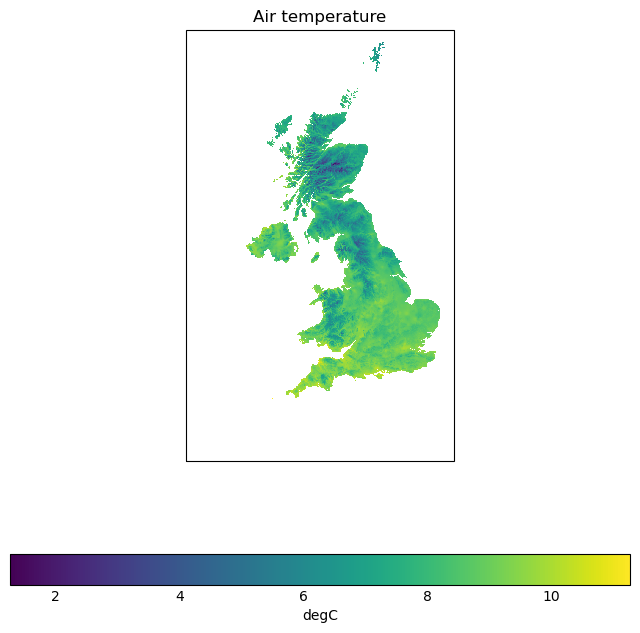

In [35]:
plt.figure(figsize=(8,8))
qplt.pcolormesh(air_temp[0])
print(air_temp[0])
 #notice how time has moved to a scalar coordinate

Looking at the plot we have produced, by using `qplt` we get a title, labeled `colorbar` with units as well as the map.
`pcolormesh` is a standard `matplotlib` plotting tool and is used for plotting 2D fields

## Section 2 

### Subsetting a cube

In the next part of this notebook, we will look a little deeper into extract different sections of a cube and producing more visualisations. Ill load in a new cube to use here, which looks at rainfall over a month, with a time-point everyday

In [36]:
rainfall = iris.load_cube(paths_to_data[1]) # load our cube

/var/tmp/ipykernel_22849/979896613.py:1: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  rainfall = iris.load_cube(paths_to_data[1]) # load our cube


In [37]:
rainfall

<iris 'Cube' of lwe_thickness_of_precipitation_amount / (mm) (time: 31; projection_y_coordinate: 110; projection_x_coordinate: 83)>

Having a look at time again now, we can use our `.cell()` method we have already seen to index different parts of our time coordinate. indexing(-1) gets the lazy element of the array, so we can print both to get a concise look at the start and end of our time coordinates

In [38]:
print(rainfall.coord('time').cell(0))
print(rainfall.coord('time').cell(-1))
# looks like we have the full month of january

Cell(point=cftime.DatetimeGregorian(1891, 1, 1, 12, 0, 0, 0, has_year_zero=False), bound=(cftime.DatetimeGregorian(1891, 1, 1, 9, 0, 0, 0, has_year_zero=False), cftime.DatetimeGregorian(1891, 1, 2, 9, 0, 0, 0, has_year_zero=False)))
Cell(point=cftime.DatetimeGregorian(1891, 1, 31, 12, 0, 0, 0, has_year_zero=False), bound=(cftime.DatetimeGregorian(1891, 1, 31, 9, 0, 0, 0, has_year_zero=False), cftime.DatetimeGregorian(1891, 2, 1, 9, 0, 0, 0, has_year_zero=False)))


* it would be nice to know how rainfall varies over the month 
    * We can do this by collapsing the cube over given dimensions and giving a type of analysis
    * eg iris.analysis.MEAN finds the means of all the points
    * this will return the mean rainfall amount for the x-y plane at each timepoint
    * this can then be plotted as a time series to see how mean rainfall varies over the month

[iris.analysis](https://scitools-iris.readthedocs.io/en/stable/generated/api/iris/analysis.html?highlight=iris.analysis) comes with loads of different statistics

In [39]:
rainfall_mean = rainfall.collapsed((['projection_y_coordinate', 'projection_x_coordinate']), iris.analysis.MEAN)
rainfall_std = rainfall.collapsed((['projection_y_coordinate', 'projection_x_coordinate']), iris.analysis.STD_DEV)

/home/h02/hsouth/.conda/envs/spaceapps-mo-data/lib/python3.10/site-packages/iris/coords.py:2217: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/h02/hsouth/.conda/envs/spaceapps-mo-data/lib/python3.10/site-packages/iris/coords.py:2217: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/home/h02/hsouth/.conda/envs/spaceapps-mo-data/lib/python3.10/site-packages/iris/coords.py:2217: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/h02/hsouth/.conda/envs/spaceapps-mo-data/lib/python3.10/site-packages/iris/coords.py:2217: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


Using `quickplot.plot` we can quickly plot the time series

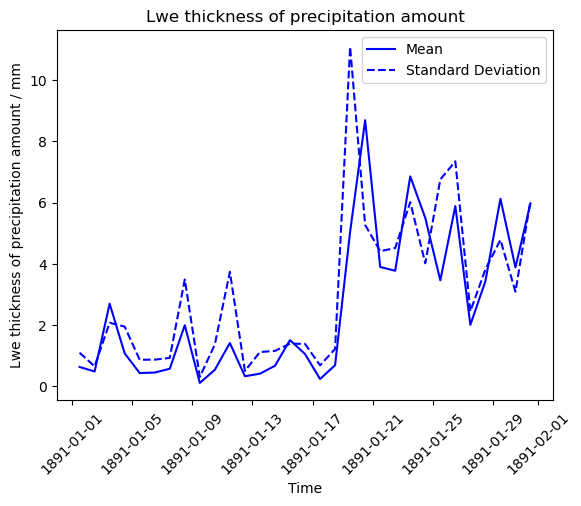

In [40]:
qplt.plot(rainfall_mean,'b-',label='Mean')
qplt.plot(rainfall_std,'b--',label='Standard Deviation')
# we can combine with matplotlib functionality to make our plot more readable
plt.xticks(rotation=45)
plt.legend()

* its simple then to plot the slice of the cube where rainfall increases, looks like the 20th from the graph
* we can easily index this slice and plot it to see what the map looks like

Cell(point=cftime.DatetimeGregorian(1891, 1, 20, 12, 0, 0, 0, has_year_zero=False), bound=(cftime.DatetimeGregorian(1891, 1, 20, 9, 0, 0, 0, has_year_zero=False), cftime.DatetimeGregorian(1891, 1, 21, 9, 0, 0, 0, has_year_zero=False)))


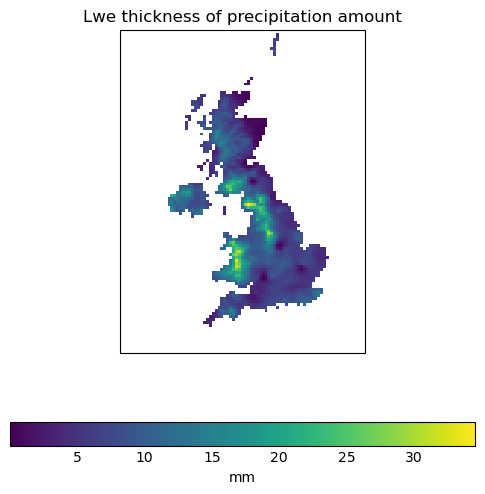

In [41]:
plt.figure(figsize=(6,6))
qplt.pcolormesh(rainfall[19]) #20th is at 19 since we use 0 indexing in python
print(rainfall.coord('time').cell(19)) # double check we have the righy date 

okay so this looks good, but what about investigating different parts of the uk?

Here we will use constraints to extract parts of the uk using the projected x and y coordinate. I used some trial and error to get the values i wanted to extract between however i accessed the coordinates to view their range

First ill set up some functions for the constraints to make the code a bit cleaner

In [42]:
# making some functions to constrain produce constraints
def y_constraint(y_min,y_max):
    y_constraint = iris.Constraint(projection_y_coordinate=lambda cell: y_min < cell < y_max)
    return y_constraint

def x_constraint(x_min,x_max):
    x_constraint = iris.Constraint(projection_x_coordinate=lambda cell: x_min < cell < x_max)
    return x_constraint

Next ill print the min and max of the x,y coordinates to see the range of values i can extract from

In [46]:
print('y coordinate minimum {}' .format(rainfall.coord('projection_y_coordinate').points.min()))
max_y = rainfall.coord('projection_y_coordinate').points.max()
print('y coordinate maximum {}' .format(rainfall.coord('projection_y_coordinate').points.max()))
print('x coordinate minimum {}' .format(rainfall.coord('projection_x_coordinate').points.min()))
print('x coordinate maximum {}' .format(rainfall.coord('projection_x_coordinate').points.max()))

y coordinate minimum -87500.0
y coordinate maximum 1220500.0
x coordinate minimum -187500.0
x coordinate maximum 796500.0


In [47]:
north_west = rainfall.extract(x_constraint(-100000,350000) & y_constraint(350000,max_y))
north_east = rainfall.extract(x_constraint(350000,700000) & y_constraint(350000,max_y))
south_west = rainfall.extract(x_constraint(-100000,450000) & y_constraint(10000,350000))
south_east = rainfall.extract(x_constraint(450000,700000) & y_constraint(10000,350000))

* i did'nt choose midpoint and edges of the coordinate to split the cube into 4 as the UK is on an angle 
* i choose these constraints to get rough region split 
* feel free to play around with the constraints and extract different parts of the UK 
* each extracted region, is now just a smaller subset of the larger rainfall cube

In [48]:
print(north_west)

lwe_thickness_of_precipitation_amount / (mm) (time: 31; projection_y_coordinate: 72; projection_x_coordinate: 37)
    Dimension coordinates:
        time                                      x                            -                            -
        projection_y_coordinate                   -                            x                            -
        projection_x_coordinate                   -                            -                            x
    Auxiliary coordinates:
        latitude                                  -                            x                            x
        longitude                                 -                            x                            x
    Cell methods:
        sum                                  time
    Attributes:
        Conventions                          'CF-1.5'
        collection                           'HadUK-Grid v1.0.0.0'
        comment                              'Daily resolution gridded climat

Now lets plot each region using subplots

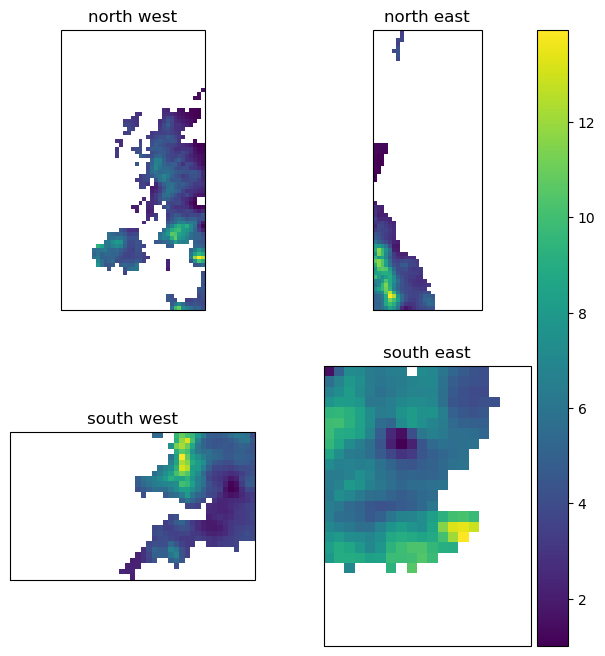

In [49]:
fig, axes = plt.subplots(figsize = (8,8),nrows=2, ncols=2)
plt.subplot(2,2,1)
plt.title('north west')
im = iplt.pcolormesh(north_west[19])
plt.subplot(2,2,2)
plt.title('north east')
im = iplt.pcolormesh(north_east[19])
plt.subplot(2,2,3)
plt.title('south west')
im = iplt.pcolormesh(south_west[19])
plt.subplot(2,2,4)
plt.title('south east')
im = iplt.pcolormesh(south_east[19])
fig.colorbar(im , ax=axes.ravel().tolist())
plt.subplots_adjust(right=0.8)

We can make time series again to compare the mean of each region! 

In [50]:
north_west_mean = north_west.collapsed((['projection_y_coordinate', 'projection_x_coordinate']), iris.analysis.MEAN)
north_east_mean = north_east.collapsed((['projection_y_coordinate', 'projection_x_coordinate']), iris.analysis.MEAN)
south_east_mean = south_east.collapsed((['projection_y_coordinate', 'projection_x_coordinate']), iris.analysis.MEAN)
south_west_mean = south_west.collapsed((['projection_y_coordinate', 'projection_x_coordinate']), iris.analysis.MEAN)


/home/h02/hsouth/.conda/envs/spaceapps-mo-data/lib/python3.10/site-packages/iris/coords.py:2217: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/h02/hsouth/.conda/envs/spaceapps-mo-data/lib/python3.10/site-packages/iris/coords.py:2217: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/home/h02/hsouth/.conda/envs/spaceapps-mo-data/lib/python3.10/site-packages/iris/coords.py:2217: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/home/h02/hsouth/.conda/envs/spaceapps-mo-data/lib/python3.10/site-packages/iris/coords.py:2217: UserWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/home/

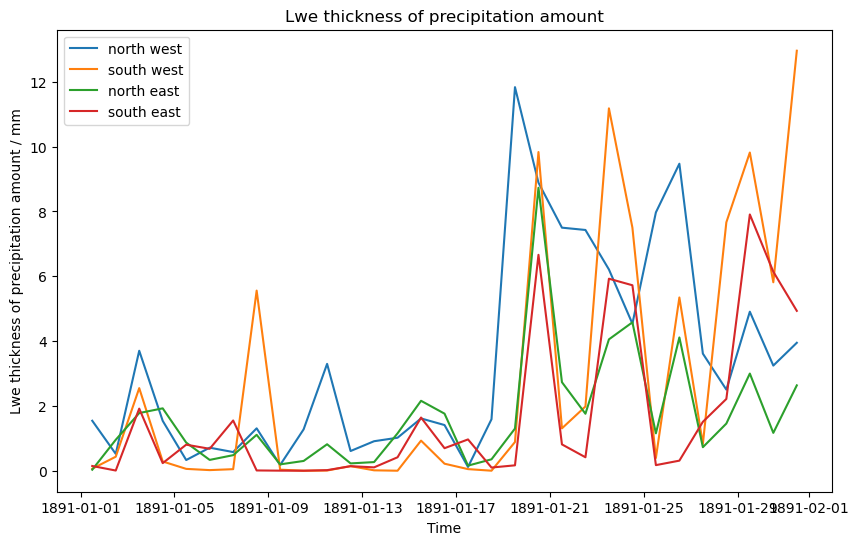

In [51]:
plt.figure(figsize=(10,6))
qplt.plot(north_west_mean,label='north west')
qplt.plot(south_west_mean,label='south west')
qplt.plot(north_east_mean,label='north east')
qplt.plot(south_east_mean,label='south east')
plt.legend()
# if you prefer to add your own titles and labels, use iplt (iris.plot) and add labels ect using matplotlib


## Section 3

##### Concatenating cubes

* being able to [concatenate and merge](https://scitools-iris.readthedocs.io/en/stable/userguide/merge_and_concat.html) cubes together is a very useful skill
* it allows longer time series of data to be in the same cube, making data processing and visualisations much easier


First lets load in two cubes to the same cubelist, concatenate works from a cubelist, so its worth trying this first

In [52]:
rainfall_cubelist = iris.load([paths_to_data[2], paths_to_data[3]])

/var/tmp/ipykernel_22849/1184783948.py:1: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  rainfall_cubelist = iris.load([paths_to_data[2], paths_to_data[3]])
/var/tmp/ipykernel_22849/1184783948.py:1: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  rainfall_cubelist = iris.load([paths_to_data[2], paths_to_data[3]])


In [53]:
rainfall_cubelist

[<iris 'Cube' of lwe_thickness_of_precipitation_amount / (mm) (time: 31; projection_y_coordinate: 110; projection_x_coordinate: 83)>,
<iris 'Cube' of lwe_thickness_of_precipitation_amount / (mm) (time: 28; projection_y_coordinate: 110; projection_x_coordinate: 83)>]

In [54]:
print(rainfall_cubelist[0])
print(rainfall_cubelist[1])

lwe_thickness_of_precipitation_amount / (mm) (time: 31; projection_y_coordinate: 110; projection_x_coordinate: 83)
    Dimension coordinates:
        time                                      x                            -                             -
        projection_y_coordinate                   -                            x                             -
        projection_x_coordinate                   -                            -                             x
    Auxiliary coordinates:
        latitude                                  -                            x                             x
        longitude                                 -                            x                             x
    Cell methods:
        sum                                  time
    Attributes:
        Conventions                          'CF-1.5'
        collection                           'HadUK-Grid v1.0.0.0'
        comment                              'Daily resolution gridded 

A quick scan over the dimensions and metadata it looks like everything matches (it should really its from the same version of the same database!) 
Lets try concatenate the cubes 
We can either use concatenate_cubes() or concatenate() , i prefer concatenate_cubes() as it returns a cube or throws an error if it cant concatenate, whereas concatenate() returns a cubelist and will just return the original cubelist if no concatenation can be done  

In [56]:
try:
    rainfall_cubelist.concatenate_cube()
except Exception as e:
    print("Error:", e)
    

Error: failed to concatenate into a single cube.
  Cube metadata differs for phenomenon: lwe_thickness_of_precipitation_amount


so it seems some metadata differs after all! This is usually the case, luckily iris has a very useful function that can help us fix this quickly 
* [iris.util](https://scitools-iris.readthedocs.io/en/stable/generated/api/iris/util.html?highlight=utils#iris-util) has loads of very useful functions, id recommend checking out the docs here 
* we will use describe_diff to see what the differences are 
* we can then use equalise_attributes to delete the differing metadata - easy!

In [57]:
iris.util.describe_diff(rainfall_cubelist[0],rainfall_cubelist[1])

"creation_date" cube_a attribute value "2018-11-19T13:36:17" is not compatible with cube_b attribute value "2018-11-19T13:37:27"


In [58]:
iris.util.equalise_attributes(rainfall_cubelist)

[{'creation_date': '2018-11-19T13:36:17'},
 {'creation_date': '2018-11-19T13:37:27'}]

In [59]:
iris.util.describe_diff(rainfall_cubelist[0],rainfall_cubelist[1])

Cubes are compatible


Note we equalise attributes over the cubelist, so cubes in the list will then be compatible

In [60]:
jan_feb_rainfall = rainfall_cubelist.concatenate_cube()
print(jan_feb_rainfall)

lwe_thickness_of_precipitation_amount / (mm) (time: 59; projection_y_coordinate: 110; projection_x_coordinate: 83)
    Dimension coordinates:
        time                                      x                            -                             -
        projection_y_coordinate                   -                            x                             -
        projection_x_coordinate                   -                            -                             x
    Auxiliary coordinates:
        latitude                                  -                            x                             x
        longitude                                 -                            x                             x
    Cell methods:
        sum                                  time
    Attributes:
        Conventions                          'CF-1.5'
        collection                           'HadUK-Grid v1.0.0.0'
        comment                              'Daily resolution gridded 

Ill leave it down to the reader to rerun plots, or change regions and plot some time series!

Can also get some more data from ceda, make a larger cube with more data to plot!

Finally, a quick warning with `equalise_attributes` and describe_diff
* Not all differences are picked up, therefore wont be removed by equalise attributes either!
* A blocker i usually find when trying to concatenate is a coordinate forecast_period which these cubes don't have 
* To get around this, or any other coordinates which may be preventing concatenate, coordinates can be removed from a cube manually, for example: cube.remove_coord('forecast_period')
* other things that can be tricky is if the cubes coordinate metadata differs, this hopefully should'nt be the case, but its worth looking into if you're stuck 


#### Lazy data

* When a cube is loaded, the data is loaded as 'lazy data' meaning its not committed to memory
* Many iris operations just use lazy data, however some will commit data to memory
    * for example accessing a cubes data vid cube.data commits data to memory
* If you're having memory issues, check if a cubes data is lazy
* if its not you can commit it back to being lazy data

In [61]:
jan_feb_rainfall.has_lazy_data()

True

This should return True at this point, lets load into memory to return False

In [62]:
data = jan_feb_rainfall.data # this loads data into memory
del data # ill delete it straight away as i dont actually want it sat in memory

In [63]:
jan_feb_rainfall.has_lazy_data()

False

Its easy to commit our cubes data back to being lazy

In [64]:
jan_feb_rainfall.data = jan_feb_rainfall.lazy_data()

In [65]:
jan_feb_rainfall.has_lazy_data()

True

Now our data is lazy again! Lots of iris operations use lazy data, its a great functionality of iris. So if you are ever struggling with memory issues, check if data is lazy and if not making lazy! 

#### Exploring masked data

* Cube data is usually in thr form of a masked numpy array, even if no data is masked
* Sometimes the land or sea are masked instead
* see the [numpy mask module](https://numpy.org/doc/stable/reference/maskedarray.generic.html)
    * useful for making new masks based on data, for example masking 0s 

Firstly if we just print our data, we will see a data array and a masked array 

In [66]:
rainfall.data

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        ...,

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --,

WE can extract the mask by doing: rainfall.data.mask

or we can extract the raw data by doing: rainfall.data.data 
note by doing this, previously masked points will be filled with a value of 1e+20

In [67]:
mask = rainfall.data.mask

We can plot a slice of our mask using pcolormesh 

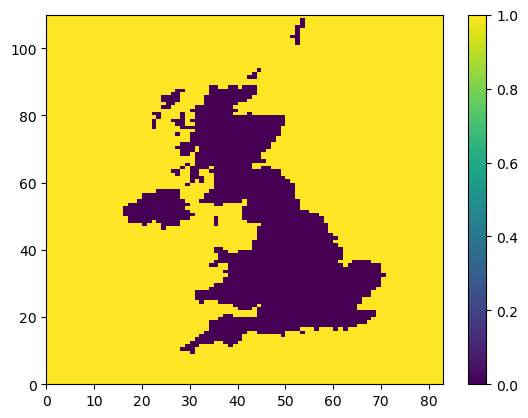

In [68]:
plt.pcolormesh(mask[0])
plt.colorbar()

As i said before we can extract just the data from the cube, so lets do that 

First lets make a copy of our cube, that we will assign the unmasked data to

In [69]:
rainfall_no_mask = rainfall.copy()

Now we can assign our data

In [70]:
rainfall_no_mask.data = rainfall.data.data
# while were here lets make it lazy data
rainfall_no_mask.data = rainfall_no_mask.lazy_data()
rainfall_no_mask.has_lazy_data()

True

If we plot our map now, we will see its dominated by the fill value

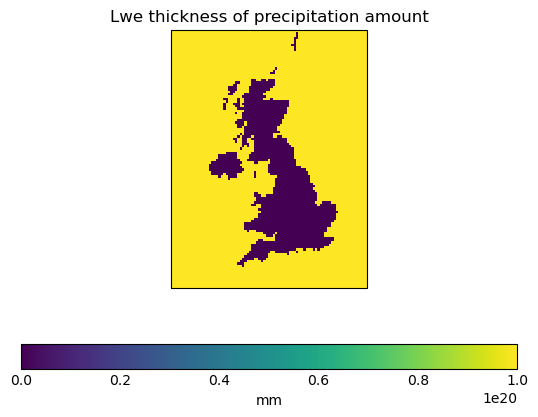

In [71]:
qplt.pcolormesh(rainfall_no_mask[0])

Notice the 1e20 on the scale!

Often model data will come with a land/sea mask, so if you were only interested in investigating the sea you could mask the land! or using the `numpy.ma` module 

Since we already have our mask, we can use iris.util.mask_cube() 

In [72]:
iris.util.mask_cube(rainfall_no_mask,mask)

<iris 'Cube' of lwe_thickness_of_precipitation_amount / (mm) (time: 31; projection_y_coordinate: 110; projection_x_coordinate: 83)>

The sea will now be masked again!!

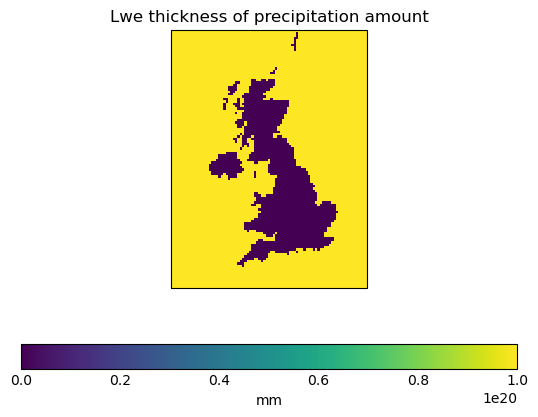

In [73]:
qplt.pcolormesh(rainfall_no_mask[0])

## Section 4

## Lets make some more plots to look at the statistics of our cube

Plotting a histogram to view our data

* y-axis is logged since rainfall is an exponential function

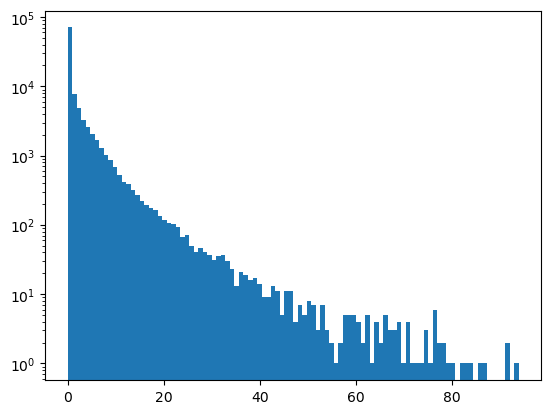

In [74]:
data = jan_feb_rainfall.data.ravel() # ravel() flattens a data array
plt.hist(data,bins = 100,log=True)
del data

Lets add some of our metadata from our cube to make this plot more readable

In [75]:
jan_feb_rainfall.attributes['plot_label']

'Total rainfall (mm)'

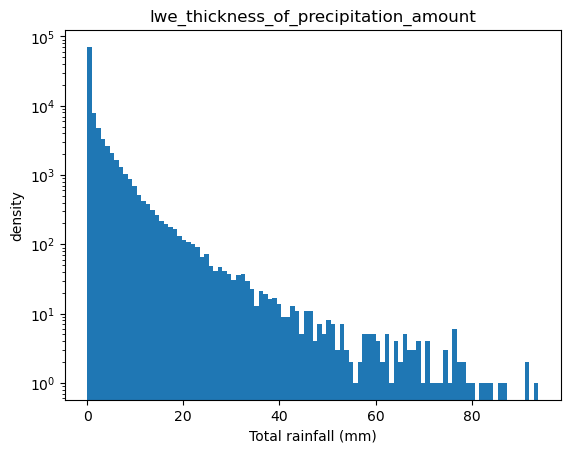

In [76]:
title = jan_feb_rainfall.standard_name
units = jan_feb_rainfall.units
x_label = jan_feb_rainfall.attributes['plot_label']
data = jan_feb_rainfall.data.ravel() # ravel() flattens a data array
plt.hist(data,bins = 100,log=True)
plt.title(title)
plt.xlabel(x_label)
plt.ylabel('density')
del data


note i added data as a variable and then deleted it, this is because iris loads cubes with 'lazy data' so data is committed to memory, but accessing the data using .data commits all data to memory, so i delete this variable after use so im keeping as much memory available as possible

# Boxplots and summary of statistics

* Box plots don't deal well with masked data so we need to extract the true data
* We will use the data from part 1 as its less to load to memory 
* To get the actual data, we will extract the data where the mask is equal to false

In [77]:
data = air_temp[0].data
mask = air_temp[0].data.mask
true_data = data[mask == False]

In [78]:
print(true_data)
print(type(true_data))
# need to get the data to numpy array
true_data = true_data.data
print(type(true_data))


[11.246220240412502 11.241558629226391 11.24392582632405 ...
 6.431115858037315 5.519154151463566 6.117374831834085]
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ndarray'>


{'whiskers': [<matplotlib.lines.Line2D at 0x2b7295f84b80>,
 'caps': [<matplotlib.lines.Line2D at 0x2b7295f84460>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b7295f84df0>],
 'medians': [<matplotlib.lines.Line2D at 0x2b7295f86ec0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b7295f87d00>],
 'means': [<matplotlib.lines.Line2D at 0x2b7295f87820>]}

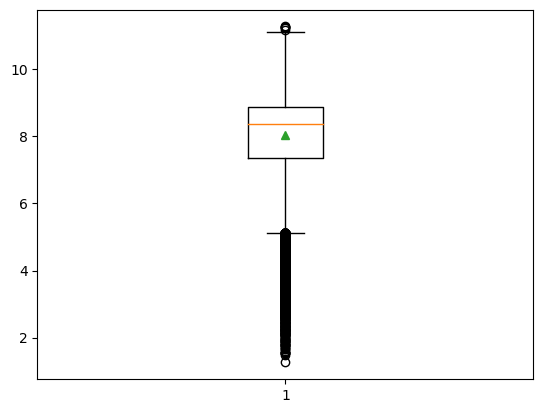

In [79]:
plt.boxplot(true_data.ravel(),showmeans=True)

We can see that the boxplot also produces a dictionary with all the values as matplotlib objects. We can extract the data from this but its a bit of a faff. Instead lets use a scipy library 

In [80]:
import scipy
from scipy import stats 

In [81]:
stats.describe(true_data.ravel())

DescribeResult(nobs=244442, minmax=(1.2609452214698846, 11.273013853893774), mean=8.050559122328917, variance=1.410272434028306, skewness=-1.0449847784920772, kurtosis=1.2509155032329033)

We could also put into a pandas dataframe and use `.describe()`

In [82]:
import pandas as pd
df = pd.DataFrame(true_data.ravel(),columns = ['air_temp_values'])
df.describe()

,air_temp_values
count,244442.000000
mean,8.050559
std,1.187549
min,1.260945
25%,7.364881
50%,8.367672
75%,8.863038
max,11.273014


<AxesSubplot: >

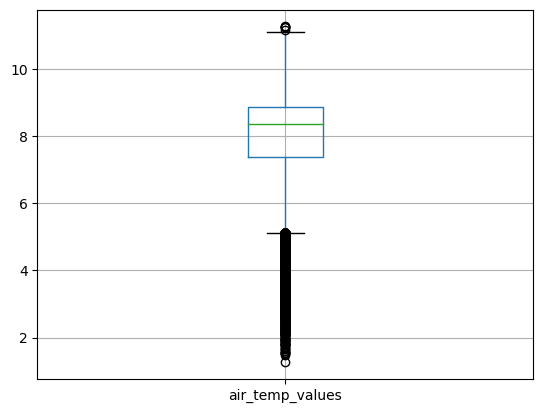

In [83]:
df.boxplot()